<a href="https://colab.research.google.com/github/farhannaushad08/Deep-Learning-Journey/blob/main/CNN_09_Transfer_learning_feature_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Fine-Tuning** is the process of unfreezing some of the top layers of a pre-trained model (such as VGG16, ResNet, or Inception) and jointly training both these layers and the newly added fully connected layers on the new dataset.

In transfer learning, the model initially acts as a fixed feature extractor, where only the custom classifier is trained.
Fine-tuning goes one step further — by slightly updating the weights of the deeper convolutional layers, the model can learn task-specific patterns from the new dataset while still retaining the general visual knowledge learned from ImageNet.

This helps improve model accuracy and generalization, especially when the new dataset is similar to the original dataset used for pretraining.

**Importing dataset from kaggle**

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d tongpython/cat-and-dog

Dataset URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog
License(s): CC0-1.0
 52% 114M/218M [00:00<00:00, 1.19GB/s]
100% 218M/218M [00:00<00:00, 790MB/s] 


**Extract zip file**

In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/cat-and-dog.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

**Importing essential library**

In [4]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16

**Import Pretrained VGG Model
Only importing conv part**

In [5]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,# skipping dense layer
    input_shape=(150,150,3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [6]:
#freeze all the conv part excluding last conv layer
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_layer False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [7]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

**Adding FC Layer**

In [8]:
model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,353 (64.13 MB)

 Trainable params: 9,177,089 (35.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

**Load the data using generator**




In [10]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/training_set/training_set',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = '/content/test_set/test_set',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(150,150)
)

Found 8005 files belonging to 2 classes.
Found 2023 files belonging to 2 classes.


In [11]:
# Normalize
def process(image,label):
    image = tensorflow.cast(image/255. ,tensorflow.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

While compiling model for fine tune we use rmsprop optimizer and learning rate should be low

In [13]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
  )

In [14]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 56s 174ms/step - accuracy: 0.8210 - loss: 0.3982 - val_accuracy: 0.9071 - val_loss: 0.2123
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 37s 147ms/step - accuracy: 0.9250 - loss: 0.1794 - val_accuracy: 0.8957 - val_loss: 0.2522
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 37s 146ms/step - accuracy: 0.9516 - loss: 0.1257 - val_accuracy: 0.9298 - val_loss: 0.1759
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 37s 146ms/step - accuracy: 0.9670 - loss: 0.0893 - val_accuracy: 0.9367 - val_loss: 0.1561
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 37s 146ms/step - accuracy: 0.9825 - loss: 0.0598 - val_accuracy: 0.9333 - val_loss: 0.1773
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 37s 146ms/step - accuracy: 0.9886 - loss: 0.0424 - val_accuracy: 0.9362 - val_loss: 0.1712
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 37s 146ms/step - accuracy: 0.9911 - loss: 0.0304 - val_accuracy: 0.9387 - val_loss: 0.1698
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 37s 147ms/step - accuracy: 0.9964 - loss: 0

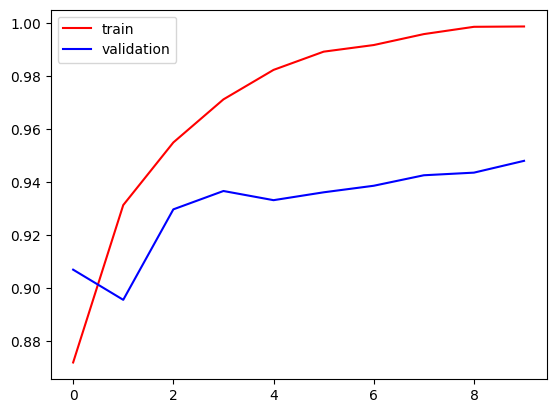

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

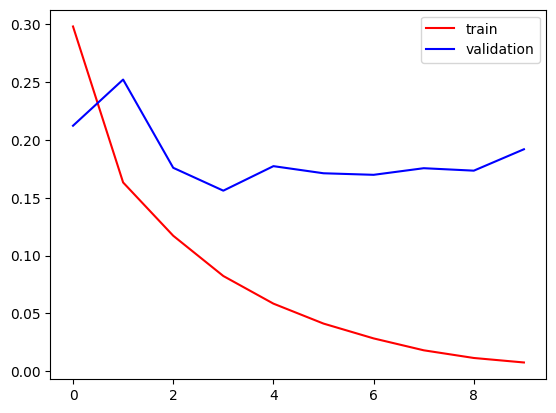

In [16]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

**Conclusion:**
In this project, we implemented Transfer Learning using the pre-trained VGG16 model for binary image classification (Cats vs Dogs).
We froze all convolutional layers except the last one to retain the pre-learned ImageNet features while allowing the final convolutional block to fine-tune on our dataset.
Custom fully connected layers were added on top, and only these layers along with the last convolutional block were trained.

This approach achieved strong performance, with the training accuracy improving steadily and reaching ~99.8%, and validation accuracy stabilizing around 94.8% after 10 epochs.
The results indicate that fine-tuning the upper convolutional layers improved the model’s ability to adapt to the cat–dog classification task while maintaining good generalization and robustness